# Notebook 1a: Models without Covid Testing Data 

This notebook trains, tests, and deployes the best model onto all the US counties. It uses the final_fl_df.csv file to run a grid of models. More precisely, it runs the following models, with the indicated parameters:

- LinearRegression: 'fit_intercept': (True, False)
- Ridge: 'alpha': 1, 50, 100, 1000
- Lasso: 'alpha': 1, 50, 100, 1000
- DecisionTreeRegressor:  
    - 'criterion': 'mse', 'mae',
    - 'max_depth': 1, 3, 5,
    - 'min_samples_split': 2, 5, 10
- RandomForestRegressor': 
    - 'n_estimators': 10, 100,
    - 'criterion': 'mse', 'mae',
    - 'max_depth': 1, 3, 5,
    - 'min_samples_split': 2, 5, 10

After determining that the RandomForestRegressor is the best model according to the R2 score that is employed as an evaluation metric, the notebook deploys this model onto a dataset with all the US counties.


In [150]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import ParameterGrid 

1.0 Import Final Florida Dataset
-------------------

In [151]:
condensed_ml_df = pd.read_csv('final_fl_df.csv')

In [152]:
condensed_ml_df.columns

Index(['Date', 'm50', 'm50_index', 'POP_ESTIMATE_2018',
       'Urban_Influence_Code_2013', 'Mar Temp AVG / F', 'Apr Temp AVG / F',
       'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
       'Percent of adults with less than a high school diploma 2014-18',
       'Employed_2018', 'Unemployment_rate_2018',
       'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018',
       'Density per square mile of land area - Population',
       'Density per square mile of land area - Housing units',
       'Active Physicians per 100000 Population 2018 (AAMC)',
       'All Specialties (AAMC)', 'ICU Beds',
       'transit_scores - population weighted averages aggregated from town/city level to county',
       'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
       '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
       'stay at home_bool', '>50 gatherings_bool', '>500 gatherings_bool',
       'public_schools_bool', 'dine_in_bool'

2.0 Prepare Data for Modeling
-----------------

In [153]:
#setting the baseline data (data available for all US counties)

'''
Takes out the covid non available data for all counties:
        'Age_0_14', 'Age_15_24', 'Age_25_44', 'Age_45_64', 'Age_65plus',
        'C_Female', 'C_Male', 'Subgroup_Case_Rate_Black',
        'Subgroup_Case_Rate_White', 'Subgroup_Case_Rate_Hispanic',
        'Subgroup_Case_Rate_AsianNA_NH_PI_TwoPlus', 'T_negative', 'T_positive',
        'T_total'
'''
condensed_ml_df = condensed_ml_df[['Date', 
                'm50', 'm50_index', 
                'POP_ESTIMATE_2018',
                'Urban_Influence_Code_2013', 
                'Mar Temp AVG / F', 'Apr Temp AVG / F', 
                'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
                'Percent of adults with less than a high school diploma 2014-18',
                'Employed_2018', 'Unemployment_rate_2018',
                'Median_Household_Income_2018',
                'Med_HH_Income_Percent_of_State_Total_2018',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Active Physicians per 100000 Population 2018 (AAMC)',
                'All Specialties (AAMC)', 'ICU Beds',
                'transit_scores - population weighted averages aggregated from town/city level to county',
                'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
                '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
                'Percent_White', 'Percent_Black', 
                'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
                'cases', 'deaths', 'Day_of_Week', 'Subgroup_Case_Rate_Black']]

In [154]:
#temporal split 
split_date = '2020-04-26'
train = condensed_ml_df[condensed_ml_df['Date'] <= split_date]
test = condensed_ml_df[condensed_ml_df['Date'] > split_date] 

In [155]:
#assess proportion of testing set to total data 
len(test) / (len(train) + len(test))

0.23595505617977527

In [156]:
#split into X_train and Y_train, X_test, and Y_test
test_target = 'Subgroup_Case_Rate_Black'

X_train = train.drop(columns=[test_target])
Y_train = train[test_target]

X_test = test.drop(columns=[test_target])
Y_test = test[test_target]

In [157]:
X_train.columns

Index(['Date', 'm50', 'm50_index', 'POP_ESTIMATE_2018',
       'Urban_Influence_Code_2013', 'Mar Temp AVG / F', 'Apr Temp AVG / F',
       'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
       'Percent of adults with less than a high school diploma 2014-18',
       'Employed_2018', 'Unemployment_rate_2018',
       'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018',
       'Density per square mile of land area - Population',
       'Density per square mile of land area - Housing units',
       'Active Physicians per 100000 Population 2018 (AAMC)',
       'All Specialties (AAMC)', 'ICU Beds',
       'transit_scores - population weighted averages aggregated from town/city level to county',
       'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
       '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
       'Percent_White', 'Percent_Black', 'Percent_NativeAmerican',
       'Percent_Asian', 'Percent_NativeHawaiianPI', 

In [158]:
'''
con_features = ['m50', 'm50_index',
            'Active Physicians per 100000 Population 2018 (AAMC)', 'ICU Beds',
            'Average Daily PM2.5', '% Severe Housing Problems',
            'Premature Death', 'Cardiovascular Deaths Per 100K',
            'Density per square mile of land area - Population',
            'Density per square mile of land area - Housing units',
            'Median_Household_Income_2018', 'Percent_White', 'Percent_Black', 'Percent_NativeAmerican',
            'Percent_Asian', 'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
            'Age_0_14', 'Age_15_24', 'Age_25_44', 'Age_45_64', 'Age_65plus',
            'cases', 'deaths']
'''

con_features = ['m50', 'm50_index', 
                'POP_ESTIMATE_2018',
                'Urban_Influence_Code_2013', 
                'Mar Temp AVG / F', 'Apr Temp AVG / F', 
                'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
                'Percent of adults with less than a high school diploma 2014-18',
                'Employed_2018', 'Unemployment_rate_2018',
                'Median_Household_Income_2018',
                'Med_HH_Income_Percent_of_State_Total_2018',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Active Physicians per 100000 Population 2018 (AAMC)',
                'All Specialties (AAMC)', 'ICU Beds',
                'transit_scores - population weighted averages aggregated from town/city level to county',
                'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
                '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
                'Percent_White', 'Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
                'cases', 'deaths', 'Day_of_Week']

In [159]:
#normalize function 
def normalizer(df, cols, scaler=None):
    '''
    Standardizes continuous features separately for training and testing 
    '''
    if not scaler:
        scaler = StandardScaler()
        if len(cols) == 1:
            scaler.fit(df[cols].values.reshape(-1, 1))
        else:
            scaler.fit(df[cols])

    normalized = scaler.transform(df[cols])
    norm_cols = pd.DataFrame(normalized)
    norm_cols.index = df.index
    norm_cols.columns = df[cols].columns

    df[cols] = norm_cols

    return df, scaler

In [160]:
#spell out continuous features, normalize
X_train.loc[:, con_features], norm = normalizer(X_train, con_features)
X_test.loc[:, con_features], norm = normalizer(X_test, con_features, norm)

#drop dates from training and testing features 
X_train.drop(columns=['Date'], inplace=True)
X_test.drop(columns=['Date'], inplace=True)

3.0 Modeling
----------

In [161]:
# Setting up cross validation using TimeSeriesSplit 

time_split = TimeSeriesSplit(n_splits=5) 

#checking that cross validation split is walk forward approach; meaning that cross val is always future predicting 
for train_index, test_index in time_split.split(X_train):
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135] TEST: [136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 

In [162]:
#building the pipeline and hyperparameter grid
models = {'LinearRegression': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
          'RandomForestRegressor': RandomForestRegressor(random_state=0)
         }

params = {'LinearRegression': {'fit_intercept': (True, False)},
          'Ridge': {'alpha': [1, 50, 100, 1000]},
          'Lasso': {'alpha': [1, 50, 100, 1000]},
          'DecisionTreeRegressor': {'criterion': ['mse', 'mae'],
                                    'max_depth': (1, 3, 5),
                                    'min_samples_split': (2, 5, 10)},
          'RandomForestRegressor':{'n_estimators': (10, 100),
                                   'criterion': ['mse', 'mae'],
                                   'max_depth': (1, 3, 5),
                                   'min_samples_split': (2, 5, 10)}
         }

eval_metrics = {'mean_abs_error': make_scorer(mean_absolute_error),
                'mean_sqrd_error': make_scorer(mean_squared_error),
                'r2_Score': make_scorer(r2_score)
                }

In [163]:
#initialize dict of best estimators per model type 
best_estimators = {} 
results_dfs = [] 
for i, model in enumerate(models):
    print(i, model)
    #apply grid search to specific model and corresponding param_grid 
    grid_srch = GridSearchCV(estimator=models[model],
                            param_grid=params[model], 
                            cv=time_split, 
                            return_train_score=False, 
                            scoring = eval_metrics,
                            refit='r2_Score')
    grid_srch.fit(X_train, Y_train.values.ravel())
    
    #create grid search results df for model; add to master grid search df 
    results_df = pd.DataFrame.from_dict(grid_srch.cv_results_)
    results_df['Model_Name'] = model
    results_dfs.append(results_df)
    if i == 0:
        master_res_df = results_df
    else:
        print("Model is processing...")
        master_res_df = pd.concat([master_res_df, results_df], sort=True, ignore_index=True)
        print(master_res_df.shape)
    
    #extract best estimator from each model type; add to dictionary
    best_est = grid_srch.best_estimator_
    best_estimators[model] = best_est
    

0 LinearRegression
1 Lasso
Model is processing...
(6, 32)
2 Ridge
Model is processing...
(10, 32)
3 DecisionTreeRegressor
Model is processing...
(28, 35)
4 RandomForestRegressor
Model is processing...
(64, 36)


In [164]:
best_estimators

{'LinearRegression': LinearRegression(fit_intercept=False),
 'Lasso': Lasso(alpha=1),
 'Ridge': Ridge(alpha=1),
 'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=0),
 'RandomForestRegressor': RandomForestRegressor(max_depth=5, random_state=0)}

In [165]:
master_res_df[['Model_Name', 'params', 'mean_test_r2_Score', 'mean_test_mean_sqrd_error']].sort_values(by='mean_test_r2_Score', ascending=False).head(10)

,Model_Name,params,mean_test_r2_Score,mean_test_mean_sqrd_error
41,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.753373,0.002121
43,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.740714,0.002209
40,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.736325,0.002247
42,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.726134,0.002321
17,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.718004,0.002317
16,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.713960,0.002338
45,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.707393,0.002455
44,RandomForestRegressor,"{'criterion': 'mse', 'max_depth': 5, 'min_samp...",0.690453,0.002548
58,RandomForestRegressor,"{'criterion': 'mae', 'max_depth': 5, 'min_samp...",0.684417,0.002760
60,RandomForestRegressor,"{'criterion': 'mae', 'max_depth': 5, 'min_samp...",0.672317,0.002888


In [166]:
master_res_df.sort_values(by='mean_test_r2_Score', ascending=False)

,Model_Name,mean_fit_time,mean_score_time,mean_test_mean_abs_error,mean_test_mean_sqrd_error,mean_test_r2_Score,param_alpha,param_criterion,param_fit_intercept,param_max_depth,...,split3_test_mean_sqrd_error,split3_test_r2_Score,split4_test_mean_abs_error,split4_test_mean_sqrd_error,split4_test_r2_Score,std_fit_time,std_score_time,std_test_mean_abs_error,std_test_mean_sqrd_error,std_test_r2_Score
41,RandomForestRegressor,0.207633,0.006806,0.027957,0.002121,0.753373,NaN,mse,NaN,5,...,0.002828,0.727282,0.036480,0.003041,0.748761,0.039666,0.000428,0.006256,0.000877,0.038793
43,RandomForestRegressor,0.208953,0.006636,0.028407,0.002209,0.740714,NaN,mse,NaN,5,...,0.002905,0.719866,0.036713,0.003161,0.738826,0.042550,0.000165,0.006065,0.000875,0.030330
40,RandomForestRegressor,0.023050,0.002686,0.028636,0.002247,0.736325,NaN,mse,NaN,5,...,0.002905,0.719790,0.036984,0.003275,0.729401,0.004395,0.000168,0.006032,0.000887,0.030612
42,RandomForestRegressor,0.022840,0.002688,0.028984,0.002321,0.726134,NaN,mse,NaN,5,...,0.003169,0.694385,0.036782,0.003188,0.736560,0.004328,0.000120,0.005924,0.000893,0.030476
17,DecisionTreeRegressor,0.004011,0.002183,0.029633,0.002317,0.718004,NaN,mse,NaN,5,...,0.002614,0.747861,0.036738,0.003010,0.751282,0.000666,0.000274,0.006202,0.000746,0.047671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,RandomForestRegressor,0.669879,0.006322,0.054526,0.009642,-0.142140,NaN,mae,NaN,1,...,0.012467,-0.202389,0.070037,0.014778,-0.221038,0.377459,0.000128,0.011641,0.003755,0.065266
47,RandomForestRegressor,0.670726,0.006514,0.054526,0.009642,-0.142140,NaN,mae,NaN,1,...,0.012467,-0.202389,0.070037,0.014778,-0.221038,0.374694,0.000184,0.011641,0.003755,0.065266
19,DecisionTreeRegressor,0.015068,0.002425,0.054366,0.009723,-0.160735,NaN,mae,NaN,1,...,0.012632,-0.218206,0.069020,0.014472,-0.195723,0.008875,0.000202,0.011666,0.003603,0.043211
21,DecisionTreeRegressor,0.014478,0.002242,0.054366,0.009723,-0.160735,NaN,mae,NaN,1,...,0.012632,-0.218206,0.069020,0.014472,-0.195723,0.008101,0.000093,0.011666,0.003603,0.043211


4.0 Results
==========

4.1 RandomForestRegressor
-----------------------

In [167]:
# define the model
model_rf = best_estimators['RandomForestRegressor']

# fit the model
model_rf.fit(X_train, Y_train)

# Get feature importances
importances = model_rf.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]
labels = X_train.columns.values.tolist()

dict_df = {'Feature': labels, 'Values': indices.tolist()}
feat_importance = pd.DataFrame(dict_df).sort_values(by='Values', ascending=False)
feat_importance = feat_importance.reset_index()
feat_importance = feat_importance.drop(columns='index')
feat_importance

,Feature,Values
0,transit_scores - population weighted averages ...,34
1,Urban_Influence_Code_2013,33
2,m50,32
3,All Specialties (AAMC),31
4,ICU Beds,30
5,Med_HH_Income_Percent_of_State_Total_2018,29
6,Premature Death,28
7,Percent of adults with less than a high school...,27
8,Density per square mile of land area - Population,26
9,% Severe Housing Problems,25


Text(0.5, 1.0, 'RandomForestRegressor Prediction vs True Value ')

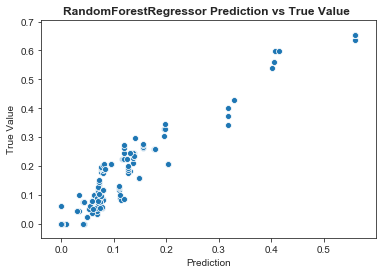

In [168]:
import matplotlib as plt
import seaborn as sns 

y_predict = model_rf.predict(X_test)
d = {'Prediction': y_predict, 'True Value': Y_test}
df = pd.DataFrame(d)

st = sns.axes_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})
rf = sns.scatterplot(x='Prediction', 
                y='True Value', 
                data=df)
rf.set_title("RandomForestRegressor Prediction vs True Value ", weight='bold') 

4.2 DecisionTreeRegressor
-----------------------

In [169]:
# define the model
model_dt = best_estimators['DecisionTreeRegressor']

# fit the model
model_dt.fit(X_train, Y_train)

# Get feature importances
importances = model_dt.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

labels = X_train.columns.values.tolist()

dict_df = {'Feature': labels, 'Values': indices.tolist()}
feat_importance = pd.DataFrame(dict_df).sort_values(by='Values', ascending=False)
feat_importance = feat_importance.reset_index()
feat_importance = feat_importance.drop(columns='index')
feat_importance

,Feature,Values
0,Total_age65plus,34
1,Urban_Influence_Code_2013,33
2,m50,32
3,ICU Beds,31
4,% Adults with Obesity,30
5,Percent_Black,29
6,Total_age18to64,28
7,Percent_Asian,27
8,Percent_TwoPlusRaces,26
9,Total_age0to17,25


Text(0.5, 1.0, 'DecisionTreeRegressor Prediction vs True Value ')

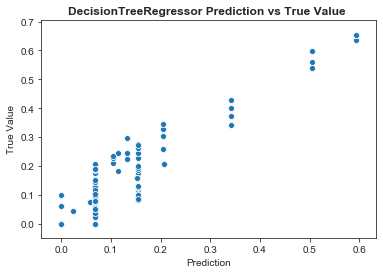

In [193]:
y_predict = model_dt.predict(X_test)
d = {'Prediction': y_predict, 'True Value': Y_test}
df = pd.DataFrame(d)

st = sns.axes_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})
dt = sns.scatterplot(x='Prediction', 
                y='True Value', 
                data=df)
dt.set_title("DecisionTreeRegressor Prediction vs True Value ", weight='bold') 

4.3 Ridge
---------------

In [171]:
# define the model
model_ridge = best_estimators['Ridge']

# fit the model
model_ridge.fit(X_train, Y_train)

# get importance
importance = model_ridge.coef_


columns = X_train.columns.values
d = {'Coeffcients': columns, 'Value': importance}
coef_df = pd.DataFrame(d)
coef_df = coef_df.sort_values(by='Value', ascending=False)
coef_df = coef_df.reset_index()
coef_df = coef_df.drop(columns='index')
coef_df

,Coeffcients,Value
0,Apr Temp AVG / F,0.153722
1,Employed_2018,0.074310
2,Average Daily PM2.5,0.059258
3,Percent_Asian,0.049361
4,Premature Death,0.033852
5,deaths,0.029965
6,cases,0.027260
7,% Adults with Obesity,0.023992
8,% Severe Housing Problems,0.023586
9,Total_age18to64,0.022390


Text(0.5, 1.0, 'Ridge Prediction vs True Value ')

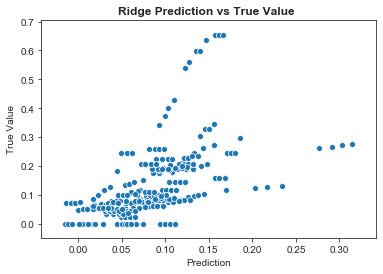

In [194]:
y_predict = model_ridge.predict(X_test)
d = {'Prediction': y_predict, 'True Value': Y_test}
df = pd.DataFrame(d)

st = sns.axes_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 1, "ytick.major.size": 1})
ridge = sns.scatterplot(x='Prediction', 
                y='True Value', 
                data=df)
ridge.set_title("Ridge Prediction vs True Value ", weight='bold') 

5.0 Deploy RandomForestRegressor over Non-Fl Counties
==========

In [174]:
all_counties = pd.read_csv('final_all_counties_df.csv')

keep = ['date', 'm50', 'm50_index', 
                'POP_ESTIMATE_2018',
                'Urban_Influence_Code_2013', 
                'Mar Temp AVG / F', 'Apr Temp AVG / F', 
                'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
                'Percent of adults with less than a high school diploma 2014-18',
                'Employed_2018', 'Unemployment_rate_2018',
                'Median_Household_Income_2018',
                'Med_HH_Income_Percent_of_State_Total_2018',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Active Physicians per 100000 Population 2018 (AAMC)',
                'All Specialties (AAMC)', 'ICU Beds',
                'transit_scores - population weighted averages aggregated from town/city level to county',
                'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
                '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
                'Percent_White', 'Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
                'cases', 'deaths', 'Day_of_Week']

In [175]:
all_counties.shape

(50059, 39)

In [176]:
all_counties.columns

Index(['FIPS', 'state', 'Area_Name', 'Date', 'm50', 'm50_index',
       'POP_ESTIMATE_2018', 'Urban_Influence_Code_2013', 'Mar Temp AVG / F',
       'Apr Temp AVG / F', 'Total_age0to17', 'Total_age18to64',
       'Total_age65plus',
       'Percent of adults with less than a high school diploma 2014-18',
       'Employed_2018', 'Unemployment_rate_2018',
       'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018',
       'Density per square mile of land area - Population',
       'Density per square mile of land area - Housing units',
       'Active Physicians per 100000 Population 2018 (AAMC)',
       'All Specialties (AAMC)', 'ICU Beds',
       'transit_scores - population weighted averages aggregated from town/city level to county',
       'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
       '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
       'Percent_White', 'Percent_Black', 'Percent_NativeAmerican',
       'Percent

In [177]:
# Time Split

split_date = '2020-04-26'
all_counties_before_date = all_counties[all_counties['Date'] <= split_date]
all_counties_after_date = condensed_ml_df[condensed_ml_df['Date'] > split_date] 

In [178]:
new_keep = ['m50', 'm50_index', 
                'POP_ESTIMATE_2018',
                'Urban_Influence_Code_2013', 
                'Mar Temp AVG / F', 'Apr Temp AVG / F', 
                'Total_age0to17', 'Total_age18to64', 'Total_age65plus',
                'Percent of adults with less than a high school diploma 2014-18',
                'Employed_2018', 'Unemployment_rate_2018',
                'Median_Household_Income_2018',
                'Med_HH_Income_Percent_of_State_Total_2018',
                'Density per square mile of land area - Population',
                'Density per square mile of land area - Housing units',
                'Active Physicians per 100000 Population 2018 (AAMC)',
                'All Specialties (AAMC)', 'ICU Beds',
                'transit_scores - population weighted averages aggregated from town/city level to county',
                'Premature Death', '% Adults with Obesity', 'Average Daily PM2.5',
                '% Severe Housing Problems', 'Cardiovascular Deaths Per 100K',
                'Percent_White', 'Percent_Black', 'Percent_NativeAmerican', 'Percent_Asian',
                'Percent_NativeHawaiianPI', 'Percent_TwoPlusRaces', 'Percent_Hispanic',
                'cases', 'deaths', 'Day_of_Week']

all_counties = all_counties[new_keep]

In [180]:
# Normalize
# Applying the same mean and std from the training data
all_counties.loc[:, new_keep], norm = normalizer(all_counties, new_keep, norm)

all_counties = all_counties.dropna()

In [183]:
y_predict = model_rf.predict(all_counties)

In [187]:
prediciton_all_counties = pd.DataFrame({'Prediction': y_predict.tolist()})

In [188]:
prediciton_all_counties.describe()

,Prediction
count,39557.000000
mean,0.085212
std,0.067814
min,0.000052
25%,0.054089
50%,0.073739
75%,0.100030
max,0.568104
